In [64]:
import pandas as pd
import numpy as np

import data_pull as dp
import geopandas as gpd

citibike_df: pd.DataFrame = dp.get_citibike_data()





In [65]:
building_df: pd.DataFrame = dp.get_building_data()
nta_demo_df: pd.DataFrame = dp.get_nta_demographics()
nta_geodf: gpd.GeoDataFrame = dp.get_nta_geog() # we have our geopandas multipolygon in the column called "geometry"
nta_geodf = nta_geodf[nta_geodf['BoroName'] != 'Staten Island']

/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: #N/A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [5]:
nta_demo_df

,GeoType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,MaleE,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
7,NTA2010,Brooklyn Heights-Cobble Hill,BK09,Brooklyn,24140,915.0,2.3,100.0,NaN,12002,...,1130,239.0,12.8,18.9,3.8,351,154.0,26.6,NaN,NaN
43,NTA2010,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,BK17,Brooklyn,66293,1721.0,1.6,100.0,NaN,31519,...,3206,387.0,7.3,28.1,3.2,812,206.0,15.4,NaN,NaN
6,NTA2010,Brighton Beach,BK19,Brooklyn,34157,1331.0,2.4,100.0,NaN,16234,...,3445,356.0,6.3,37.2,3.5,450,141.0,19.0,NaN,NaN
42,NTA2010,Seagate-Coney Island,BK21,Brooklyn,29677,1206.0,2.5,100.0,NaN,13277,...,1933,306.0,9.6,21.4,3.3,255,118.0,28.2,NaN,NaN
48,NTA2010,West Brighton,BK23,Brooklyn,15754,665.0,2.6,100.0,NaN,6943,...,1524,247.0,9.9,33.7,4.9,200,117.0,35.6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,NTA2010,Stapleton-Rosebank,SI37,Staten Island,26247,1046.0,2.4,100.0,NaN,12912,...,1677,238.0,8.6,36.4,4.5,244,109.0,27.1,NaN,NaN
146,NTA2010,New Dorp-Midland Beach,SI45,Staten Island,21358,1151.0,3.3,100.0,NaN,10367,...,748,212.0,17.2,37.7,9.1,116,77.0,40.3,NaN,NaN
139,NTA2010,Arden Heights,SI48,Staten Island,26482,905.0,2.1,100.0,NaN,13082,...,259,126.0,29.5,22.9,10.1,55,58.0,64.1,NaN,NaN
142,NTA2010,Great Kills,SI54,Staten Island,43602,1198.0,1.7,100.0,NaN,21261,...,622,185.0,18.1,24.9,6.4,252,103.0,24.8,NaN,NaN


In [66]:
data_dict = {
'Owner-occupied': 'OOcHU1E',
'Renter-occupied': 'ROcHU1E',
'Median home value(dollars)': 'MdVlE',
'Less than high school graduate': 'EA_LTHSGrE',
"Bachelor's degree or higher": 'EA_BchDHE',
'High school graduate (includes equivalency)': 'EA_HScGrdE',
'Management, business, science, and arts': 'MgBSciArtE',
'Service': 'SrvcE',
'Sales and office': 'SalesOffE',
'Natural resources, construction, and maintenance': 'NRCnstMntE',
'Production, transportation, and material moving': 'PrdTrnsMME',
'Median household income (dollars)': 'MdHHIncE',
'Mean household income (dollars)': 'MnHHIncE',
'Under .50': 'PvU50E',
'.50 to .74': 'Pv50t74E',
'.75 to .99': 'Pv75t99E',
'1.00 to 1.24': 'Pv100t124E',
'1.25 to 1.49': 'Pv125t149E',
'1.50 to 1.74': 'Pv150t174E',
'1.75 to 1.84': 'Pv175t184E',
'1.85 to 1.99': 'Pv185t199E',
'2.00 to 2.99': 'Pv200t299E',
'3.00 to 3.99': 'Pv300t399E',
'4.00 to 4.99': 'Pv400t499E',
'5.00 and over': 'Pv500plE',
'Total population': 'Pop_1E'
}

demo_cols = list(data_dict.values()) + ['GeoID']
nta_demo_df_final = nta_demo_df[demo_cols].set_index('GeoID')



In [67]:
def to_sq_mi(row):
    return row.Shape_Area * 3.587e-8

nta_geodf['area_sq_mi'] = nta_geodf.apply(to_sq_mi, axis=1)
nta_geodf['center'] = nta_geodf['geometry'].centroid
nta_geodf['center_lat'] = nta_geodf['center'].apply(lambda x: x.y)
nta_geodf['center_lng'] = nta_geodf['center'].apply(lambda x: x.x)


/var/folders/sv/b2zydtkj4_14gky1s46kj64c0000gn/T/ipykernel_40698/864184086.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nta_geodf['center'] = nta_geodf['geometry'].centroid


In [68]:
unique_start_stations = citibike_df.groupby(['start_station_id','start_lat', 'start_lng']).first()
unique_start_stations = unique_start_stations.reset_index()
unique_end_stations = citibike_df.groupby(['end_station_id','end_lat', 'end_lng']).first()
unique_end_stations = unique_end_stations.reset_index()
unique_stations = pd.concat([unique_start_stations, unique_end_stations], axis=0)
unique_stations.drop_duplicates(subset=['start_station_id', 'start_lat', 'start_lng'], inplace=True)
unique_stations = unique_stations[['start_station_id', 'start_lat', 'start_lng']].dropna()
unique_stations.columns = ['station_id', 'lat', 'lng']

## Notes:

- We need to map CitiBike Stations to NTA 2010
- We need to map Buildings to NTA 2010
- We need to map CitiBike Stations to Buildings





In [69]:
from shapely.geometry import Point
unique_stations.crs = "EPSG:4326"  # WGS 84, commonly used for lat/long coordinates
geometry = [Point(lon, lat) for lon, lat in zip(unique_stations['lng'], unique_stations['lat'])]
unique_stations_gdf = gpd.GeoDataFrame(unique_stations, geometry=geometry, crs='EPSG:4326')
unique_stations_gdf = gpd.sjoin(unique_stations_gdf, nta_geodf, how='left', op='within')
unique_stations_gdf

/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,station_id,lat,lng,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,area_sq_mi,center,center_lat,center_lng
0,72,40.767272,-73.993929,POINT (-73.99393 40.76727),139.0,1.0,Manhattan,61.0,MN15,Clinton,34570.938945,1.837385e+07,0.659070,POINT (-73.99240 40.76417),40.764165,-73.992399
1,79,40.719116,-74.006667,POINT (-74.00667 40.71912),144.0,1.0,Manhattan,61.0,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26855.031513,2.503268e+07,0.897922,POINT (-74.00475 40.72077),40.720766,-74.004748
2,82,40.711174,-74.000165,POINT (-74.00017 40.71117),85.0,1.0,Manhattan,61.0,MN27,Chinatown,20786.254613,1.450188e+07,0.520182,POINT (-73.99463 40.71561),40.715607,-73.994630
3,83,40.683826,-73.976323,POINT (-73.97632 40.68383),6.0,3.0,Brooklyn,47.0,BK68,Fort Greene,19825.520859,1.648282e+07,0.591239,POINT (-73.97488 40.69080),40.690795,-73.974881
4,116,40.741776,-74.001497,POINT (-74.00150 40.74178),138.0,1.0,Manhattan,61.0,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,45412.960917,3.705437e+07,1.329140,POINT (-73.99902 40.74758),40.747581,-73.999019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,SYS033,40.728487,-74.011693,POINT (-74.01169 40.72849),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6898,SYS035,40.728660,-74.011980,POINT (-74.01198 40.72866),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6899,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592
6900,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592


In [70]:
building_df.crs = "EPSG:4326"
geometry = [Point(lon, lat) for lon, lat in zip(building_df['longitude'], building_df['latitude'])]
buildings_gdf = gpd.GeoDataFrame(building_df, geometry = geometry, crs='EPSG:4326')

buildings_gdf_nta = gpd.sjoin(buildings_gdf, nta_geodf, how='left', op='within')


/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [71]:
import numpy as np

cat_cols = [
    'primary_property_type',
    '_2nd_largest_property_use',
    '_3rd_largest_property_use',
    'metered_areas_energy',
    'metered_areas_water',
    #'national_median_reference',
    'borough',
    #'nta',
    'estimated_data_flag',
    'estimated_data_flag_natural',
    'estimated_data_flag_fuel',
    'estimated_data_flag_fuel_1',
    'estimated_data_flag_fuel_2',
    'estimated_data_flag_fuel_3',
    'estimated_data_flag_district',
    #'estimated_data_flag_1',
    'estimated_values_energy',
    'estimated_values_water',
    'alert_data_center_issue_with',
    'alert_energy_meter_has_less',
    'alert_energy_meter_has_gaps',
    'alert_energy_meter_has',
    'alert_energy_no_meters',
    'alert_energy_meter_has_single',
    'alert_water_meter_has_less',
    'alert_property_has_no_uses'
]

num_cols = [
    'largest_property_use_type_1',
    'year_built',
    'number_of_buildings',
    'occupancy',
    #'_3rd_largest_property_use_1',
    'property_gfa_calculated_1',

    "energy_star_score",

    'site_eui_kbtu_ft',
    'weather_normalized_site_eui',
    #'national_median_site_eui',
    'site_energy_use_kbtu',
    'weather_normalized_site_energy',
    'weather_normalized_site',
    #'weather_normalized_site_1',
    'source_eui_kbtu_ft',
    'weather_normalized_source',
    'national_median_source_eui',
    'source_energy_use_kbtu',
    #'weather_normalized_source_1',
    'fuel_oil_1_use_kbtu',
    #'fuel_oil_2_use_kbtu',
    #'fuel_oil_4_use_kbtu',
    #'fuel_oil_5_6_use_kbtu',
    #'diesel_2_use_kbtu',
    'propane_use_kbtu',
    'district_steam_use_kbtu',
    'district_hot_water_use_kbtu',
    'district_chilled_water_use',
    'natural_gas_use_kbtu',
    'natural_gas_use_therms',
    #'weather_normalized_site_2',
    'electricity_use_grid_purchase',
    'electricity_use_grid_purchase_1',
    #'weather_normalized_site_3',
    #'electricity_use_grid_purchase_2',
    #'electricity_use_grid_purchase_3',
    'electricity_use_generated',
    'electricity_use_generated_1',
    #'electricity_use_generated_2',
    #'electricity_use_generated_3',
    'green_power_onsite_kwh',
    'green_power_offsite_kwh',
    'green_power_onsite_and_offsite',
    #'total_ghg_emissions_metric',
    #'direct_ghg_emissions_metric',
    'total_ghg_emissions_intensity',
    #'direct_ghg_emissions_intensity',
    #'indirect_ghg_emissions_metric',
    #'net_emissions_metric_tons',
    #'indirect_ghg_emissions',
    #'national_median_total_ghg',
    'egrid_output_emissions_rate',
    'avoided_emissions_onsite',
    'avoided_emissions_offsite',
    #'avoided_emissions_onsite_1',
    'percent_of_electricity_that',
    'percent_of_recs_retained',
    'percent_of_total_electricity',
    'water_use_all_water_sources',
    'municipally_supplied_potable',
    #'municipally_supplied_potable_1',
    #'municipally_supplied_potable_2',
    #'municipally_supplied_potable_3'
    'multifamily_housing_gross'
]

other_cols = [
    'reason_s_for_no_score',
    'energy_star_certification',
    'energy_star_certification_1',
    'annual_maximum_demand_kw',
    'annual_maximum_demand_mm',
    'annual_maximum_demand_meter',
]

date_cols = [
    'last_modified_date_property',
    'last_modified_date_electric',
    'last_modified_date_gas_meters',
    'last_modified_date_non',
    'last_modified_date_water',
    'last_modified_date_property_1'
]

cat_cols = list(set(cat_cols).intersection(buildings_gdf_nta.columns))
num_cols = list(set(num_cols).intersection(buildings_gdf_nta.columns))
other_cols = list(set(other_cols).intersection(buildings_gdf_nta.columns))
date_cols = list(set(date_cols).intersection(buildings_gdf_nta.columns))
for _col in num_cols:
    try:
        buildings_gdf_nta[_col] = buildings_gdf_nta[_col].astype(np.float64)
    except:
        print(_col)
        


electricity_use_grid_purchase
electricity_use_grid_purchase_1
natural_gas_use_kbtu
natural_gas_use_therms


In [72]:
buildings_gdf_nta.columns

Index(['property_id', 'latitude', 'longitude', 'borough',
       'primary_property_type', 'largest_property_use_type',
       'largest_property_use_type_1', 'year_built', 'construction_status',
       'number_of_buildings', 'occupancy', 'metered_areas_energy',
       'metered_areas_water', 'national_median_reference',
       'property_gfa_calculated_1', 'last_modified_date_property',
       'last_modified_date_electric', 'last_modified_date_gas_meters',
       'last_modified_date_non', 'last_modified_date_water',
       'last_modified_date_property_1', 'multifamily_housing_gross',
       'energy_star_score', 'energy_star_certification_1', 'site_eui_kbtu_ft',
       'weather_normalized_site_eui', 'national_median_site_eui',
       'site_energy_use_kbtu', 'weather_normalized_site_energy',
       'weather_normalized_site', 'weather_normalized_site_1',
       'source_eui_kbtu_ft', 'weather_normalized_source',
       'national_median_source_eui', 'source_energy_use_kbtu',
       'weather_no

In [73]:
buildings_gdf_nta['largest_property_use_type_residential'] = buildings_gdf_nta['largest_property_use_type'].apply(lambda x: 1 if x == 'Multifamily Housing' else 0)
buildings_gdf_nta['occupancy_residential'] = buildings_gdf_nta['occupancy'] * buildings_gdf_nta['largest_property_use_type_residential']
buildings_gdf_nta['occupancy_non_residential'] = buildings_gdf_nta['occupancy'] * (1 - buildings_gdf_nta['largest_property_use_type_residential'])
buildings_gdf_nta['year_built_residential'] = buildings_gdf_nta['year_built'] * buildings_gdf_nta['largest_property_use_type_residential']
buildings_gdf_nta['year_built_non_residential'] = buildings_gdf_nta['year_built'] * (1 - buildings_gdf_nta['largest_property_use_type_residential'])


In [74]:
buildings_gdf_nta['net_emissions_metric_tons'] = buildings_gdf_nta['net_emissions_metric_tons'].astype(float)

buildings_gdf_nta['net_emissions_metric_tons']


0         107.5
1         398.6
2        1323.0
7         356.7
8         379.6
          ...  
28994     198.5
28995     204.6
28996     135.8
28998     630.0
28999     261.6
Name: net_emissions_metric_tons, Length: 12652, dtype: float64

<Axes: ylabel='Frequency'>

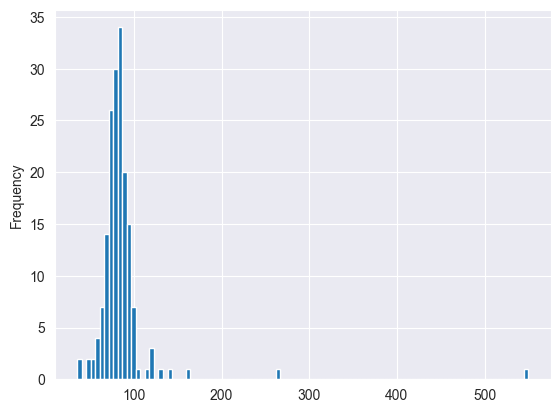

In [75]:
import seaborn as sns
col = 'site_eui_kbtu_ft'
if not buildings_gdf_nta[col].dtype == np.float64:
    buildings_gdf_nta[col] = buildings_gdf_nta[col].astype(np.float64)

buildings_gdf_nta.groupby('NTACode')[col].mean().plot(kind='hist', bins=100)

# sns.histplot(buildings_gdf_nta[col][buildings_gdf_nta[col] < buildings_gdf_nta[col].quantile(0.98)])

In [76]:
mean_non_zero = lambda x: x[x != 0].mean()

buildings_gdf_final = buildings_gdf_nta.groupby('NTACode').agg({
    'primary_property_type': 'size',
    'multifamily_housing_gross': 'sum', 
    'site_eui_kbtu_ft': 'mean',
    'largest_property_use_type_residential': lambda x: 1 if x.mean() >= 0.5 else 0,
    'occupancy_residential': mean_non_zero,
    'occupancy_non_residential': mean_non_zero,
    'year_built_residential': mean_non_zero,
    'year_built_non_residential': mean_non_zero,
    'total_ghg_emissions_intensity': 'mean',
})

In [77]:
buildings_gdf_final

,primary_property_type,multifamily_housing_gross,site_eui_kbtu_ft,largest_property_use_type_residential,occupancy_residential,occupancy_non_residential,year_built_residential,year_built_non_residential,total_ghg_emissions_intensity
NTACode,,,,,,,,,
BK09,91,8641796.0,72.554945,1,98.525641,88.846154,1941.948718,1920.384615,4.397802
BK17,91,8491196.0,85.092308,1,99.358974,95.384615,1954.628205,1979.307692,5.006593
BK19,93,7225352.0,76.434409,1,99.619565,100.000000,1950.608696,1930.000000,4.324731
BK21,23,3043205.0,119.865217,1,98.529412,96.666667,1974.647059,1981.333333,7.691304
BK23,12,7340578.0,75.583333,1,99.444444,98.333333,1959.777778,2008.000000,4.416667
...,...,...,...,...,...,...,...,...,...
QN70,96,5494585.0,87.130208,1,98.620690,98.333333,1947.379310,1954.222222,5.363542
QN71,52,3202347.0,83.228846,1,98.900000,100.000000,1976.780000,1983.500000,5.132692
QN72,44,2491035.0,87.661364,1,99.054054,95.714286,1947.783784,1960.857143,5.395455


([], [])

<Figure size 1200x1200 with 0 Axes>

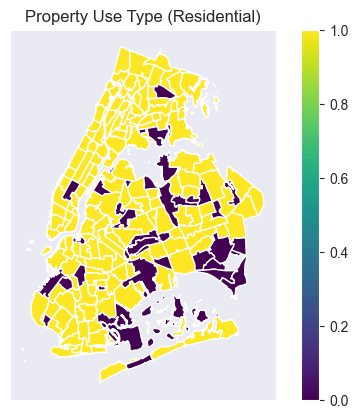

In [114]:
nta_energy_score_df = buildings_gdf_nta.groupby('NTACode').agg({
    'site_eui_kbtu_ft': 'mean'
})
plt.figure(figsize=(12, 12))
nta_energy_gdf = nta_geodf.merge(buildings_gdf_final.reset_index(), on='NTACode', how='left')
nta_energy_gdf[nta_energy_gdf['BoroName'] != 'Staten Island'].plot(column='largest_property_use_type_residential', legend=True, cmap='viridis')
plt.title('Property Use Type (Residential)')
plt.xticks([])
plt.yticks([])

In [112]:
unique_stations_gdf

,station_id,lat,lng,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,area_sq_mi,center,center_lat,center_lng
0,72,40.767272,-73.993929,POINT (-73.99393 40.76727),139.0,1.0,Manhattan,61.0,MN15,Clinton,34570.938945,1.837385e+07,0.659070,POINT (-73.99240 40.76417),40.764165,-73.992399
1,79,40.719116,-74.006667,POINT (-74.00667 40.71912),144.0,1.0,Manhattan,61.0,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26855.031513,2.503268e+07,0.897922,POINT (-74.00475 40.72077),40.720766,-74.004748
2,82,40.711174,-74.000165,POINT (-74.00017 40.71117),85.0,1.0,Manhattan,61.0,MN27,Chinatown,20786.254613,1.450188e+07,0.520182,POINT (-73.99463 40.71561),40.715607,-73.994630
3,83,40.683826,-73.976323,POINT (-73.97632 40.68383),6.0,3.0,Brooklyn,47.0,BK68,Fort Greene,19825.520859,1.648282e+07,0.591239,POINT (-73.97488 40.69080),40.690795,-73.974881
4,116,40.741776,-74.001497,POINT (-74.00150 40.74178),138.0,1.0,Manhattan,61.0,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,45412.960917,3.705437e+07,1.329140,POINT (-73.99902 40.74758),40.747581,-73.999019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,SYS033,40.728487,-74.011693,POINT (-74.01169 40.72849),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6898,SYS035,40.728660,-74.011980,POINT (-74.01198 40.72866),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6899,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592
6900,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592


([], [])

<Figure size 1200x1200 with 0 Axes>

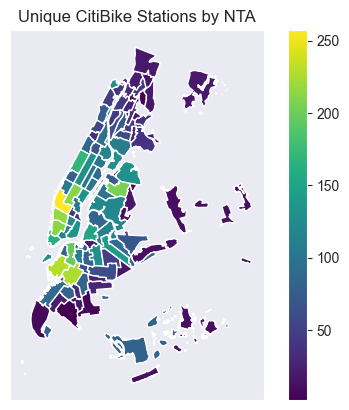

In [95]:
import matplotlib.pyplot as plt

# n rides start in nta
# n rides that end in nta
# n rides that start and end in nta
# avg length of ride
# most popular rideable type
# avg distance between start and end 


nta_stations_count = unique_stations_gdf.groupby('NTACode').size().reset_index()
plt.figure(figsize=(12, 12))
stations_by_nta_gdf = nta_geodf.merge(nta_stations_count, on='NTACode', how='left')
stations_by_nta_gdf.plot(column=0, legend=True, cmap='viridis')
plt.title('Unique CitiBike Stations by NTA')
plt.xticks([])
plt.yticks([])

# TARGET: site_eui_kbtu_ft


# FEATURES:
1) citibike dataset
    - no rides start in nta
    - no rides end in nta
    - avg duration of ride
    - number of stations in nta
    - ~~times of trips~~
2) map data
    - trip distance between center of each nta
    - elevation change between center of each nta
    - estimated time to bike above distance
3) building data (***buildings_gdf_final***)
   - [x] property types (top 3? top 1?) Aggregate?
        - residential
        - non-residential 
    - [x] occupancy
    - [x] average yr built (NOTE: BIGGER BUILDINGS ARE GONNA BE NEWER IN GENERAL)
        - residential
        - non-residential      
    - ~~green energy on/off site (maybe skip?)~~
    - ~~ghg emissions intensity (maybe skip?)~~
4) soc/econ/hous data (***nta_demo_df_final***)
    - ~~population~~
    - ~~ethnicity/race~~
    - ~~occupation type~~
    - ~~median income~~
    - ~~mean income~~
    - ~~income to poverty level~~
    - ~~owner/renter~~
        -  ~~median value of owner occupied units~~
        - 
    - ~~education~~
    - 
5) CONTROLS
    - borough
    - ~~number of buildings~~
    - population density metric
    - ~~square footage?~~

In [115]:
citibike_df = citibike_df[['started_at', 'ended_at', 'start_station_id', 'end_station_id', 'ride_duration_secs']]
citibike_df_group = citibike_df.groupby(['start_station_id', 'end_station_id']).agg({
    'started_at': 'count',
    'ended_at': 'count',
    'ride_duration_secs': 'mean'
}).reset_index()
citibike_df_group = citibike_df_group[citibike_df_group['start_station_id'] != citibike_df_group['end_station_id']]
citibike_df_group.columns = ['start_station_id', 'end_station_id', 'n_rides_start', 'n_rides_end', 'avg_ride_duration_secs']

In [116]:
citibike_df_group

,start_station_id,end_station_id,n_rides_start,n_rides_end,avg_ride_duration_secs
1,72,79,1,1,1747.900000
2,72,116,1,1,840.623000
3,72,127,1,1,1399.094000
4,72,128,2,2,1360.311500
5,72,146,1,1,1244.285000
...,...,...,...,...,...
1567357,SYS032,5170.01,1,1,1936.000000
1567358,SYS032,5250.05,1,1,402.000000
1567359,SYS032,SYS016,3,3,1086.666667
1567362,SYS035,5500.07,1,1,377.000000


In [117]:
unique_stations_gdf

,station_id,lat,lng,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,area_sq_mi,center,center_lat,center_lng
0,72,40.767272,-73.993929,POINT (-73.99393 40.76727),139.0,1.0,Manhattan,61.0,MN15,Clinton,34570.938945,1.837385e+07,0.659070,POINT (-73.99240 40.76417),40.764165,-73.992399
1,79,40.719116,-74.006667,POINT (-74.00667 40.71912),144.0,1.0,Manhattan,61.0,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26855.031513,2.503268e+07,0.897922,POINT (-74.00475 40.72077),40.720766,-74.004748
2,82,40.711174,-74.000165,POINT (-74.00017 40.71117),85.0,1.0,Manhattan,61.0,MN27,Chinatown,20786.254613,1.450188e+07,0.520182,POINT (-73.99463 40.71561),40.715607,-73.994630
3,83,40.683826,-73.976323,POINT (-73.97632 40.68383),6.0,3.0,Brooklyn,47.0,BK68,Fort Greene,19825.520859,1.648282e+07,0.591239,POINT (-73.97488 40.69080),40.690795,-73.974881
4,116,40.741776,-74.001497,POINT (-74.00150 40.74178),138.0,1.0,Manhattan,61.0,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,45412.960917,3.705437e+07,1.329140,POINT (-73.99902 40.74758),40.747581,-73.999019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6897,SYS033,40.728487,-74.011693,POINT (-74.01169 40.72849),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6898,SYS035,40.728660,-74.011980,POINT (-74.01198 40.72866),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07,0.892674,POINT (-74.00152 40.73302),40.733017,-74.001516
6899,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592
6900,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08,8.084063,POINT (-73.91959 40.62310),40.623104,-73.919592


In [118]:
citibike_df_group_mg1 = pd.merge(citibike_df_group, unique_stations_gdf[['station_id', 'NTACode', 'BoroName']], left_on='start_station_id', right_on='station_id', how='left')
citibike_df_group_mg1.drop(columns=['station_id'], inplace=True)
citibike_df_group_mg1.rename(columns={'NTACode': 'start_nta', 'BoroName': 'start_boro'}, inplace=True)
citibike_df_group_mg2 = pd.merge(citibike_df_group_mg1, unique_stations_gdf[['station_id', 'NTACode', 'BoroName']], left_on='end_station_id', right_on='station_id', how='left')
citibike_df_group_mg2.drop(columns=['station_id'], inplace=True)
citibike_df_group_mg2.rename(columns={'NTACode': 'end_nta', 'BoroName': 'end_boro'}, inplace=True)
citibike_df_group_mg2.drop_duplicates(subset=['start_station_id', 'end_station_id'], inplace=True)
citibike_df_group_mg2

,start_station_id,end_station_id,n_rides_start,n_rides_end,avg_ride_duration_secs,start_nta,start_boro,end_nta,end_boro
0,72,79,1,1,1747.900000,MN15,Manhattan,MN24,Manhattan
1,72,116,1,1,840.623000,MN15,Manhattan,MN13,Manhattan
2,72,127,1,1,1399.094000,MN15,Manhattan,MN23,Manhattan
3,72,128,2,2,1360.311500,MN15,Manhattan,MN24,Manhattan
4,72,146,1,1,1244.285000,MN15,Manhattan,MN24,Manhattan
...,...,...,...,...,...,...,...,...,...
6386212,SYS032,5170.01,1,1,1936.000000,BK78,Brooklyn,BK78,Brooklyn
6386213,SYS032,5250.05,1,1,402.000000,BK78,Brooklyn,BK90,Brooklyn
6386216,SYS032,SYS016,3,3,1086.666667,BK78,Brooklyn,BK90,Brooklyn
6386217,SYS035,5500.07,1,1,377.000000,MN23,Manhattan,MN24,Manhattan


In [119]:
citibike_start_agg = citibike_df_group_mg2.groupby('start_nta').agg(
    {
        'n_rides_start': 'sum',
        'avg_ride_duration_secs': 'mean'
    }
)
citibike_end_agg = citibike_df_group_mg2.groupby('end_nta').agg(
    {
        'n_rides_end': 'sum',
        'avg_ride_duration_secs': 'mean'
    }
)
citibike_agg = citibike_start_agg.merge(citibike_end_agg, left_index=True, right_index=True, suffixes=('_start', '_end'))
citibike_agg

,n_rides_start,avg_ride_duration_secs_start,n_rides_end,avg_ride_duration_secs_end
start_nta,,,,
BK09,252137,2181.727413,252301,1800.981875
BK31,8651,4971.726631,9071,2947.912716
BK32,83256,1959.681770,89214,2761.422835
BK33,344850,2085.826814,363347,2018.137554
BK34,31154,1937.807363,27663,2446.954809
...,...,...,...,...
QN68,153454,1678.608624,151949,2395.614926
QN70,326262,1800.754455,318447,1950.728969
QN71,106531,1660.924561,111972,2333.360949


In [121]:
citibike_agg.reset_index()

,start_nta,n_rides_start,avg_ride_duration_secs_start,n_rides_end,avg_ride_duration_secs_end
0,BK09,252137,2181.727413,252301,1800.981875
1,BK31,8651,4971.726631,9071,2947.912716
2,BK32,83256,1959.681770,89214,2761.422835
3,BK33,344850,2085.826814,363347,2018.137554
4,BK34,31154,1937.807363,27663,2446.954809
...,...,...,...,...,...
78,QN68,153454,1678.608624,151949,2395.614926
79,QN70,326262,1800.754455,318447,1950.728969
80,QN71,106531,1660.924561,111972,2333.360949
81,QN72,153177,2446.146617,153880,2914.404306


([], [])

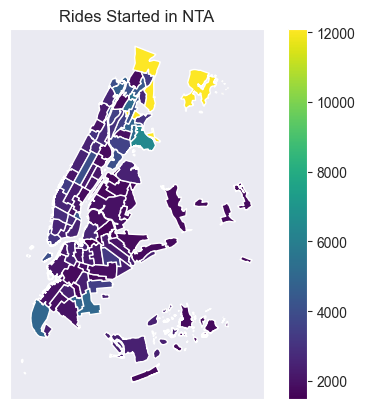

In [127]:
citi_agg_geodf = nta_geodf.merge(citibike_agg.reset_index(), left_on='NTACode', right_on='start_nta', how='left')
citi_agg_geodf.plot(column='avg_ride_duration_secs_start', legend=True, cmap='viridis')
plt.title('Rides Started in NTA')
plt.xticks([])
plt.yticks([])

In [129]:
# citibike_agg
# buildings_gdf_final
# nta_demo_df_final
station_count = unique_stations_gdf.groupby('NTACode').size().reset_index().rename({0: 'station_count'}, axis=1).set_index('NTACode')
mg1 = citibike_agg.merge(buildings_gdf_final, left_index=True, right_index=True, how='right')
mg2 = mg1.merge(nta_demo_df_final, left_index=True, right_index=True, how='left')
mg3 = mg2.merge(station_count, left_index=True, right_index=True, how='left')
mg3.to_csv('data/final_data.csv')

In [130]:
nta_geodf = nta_geodf.set_index('NTACode')

mg4 = mg3.merge(nta_geodf[['area_sq_mi']], left_index=True, right_index=True, how='left')

In [131]:
mg4

,n_rides_start,avg_ride_duration_secs_start,n_rides_end,avg_ride_duration_secs_end,primary_property_type,multifamily_housing_gross,site_eui_kbtu_ft,largest_property_use_type_residential,occupancy_residential,occupancy_non_residential,...,Pv150t174E,Pv175t184E,Pv185t199E,Pv200t299E,Pv300t399E,Pv400t499E,Pv500plE,Pop_1E,station_count,area_sq_mi
NTACode,,,,,,,,,,,,,,,,,,,,,
BK09,252137.0,2181.727413,252301.0,1800.981875,91,8641796.0,72.554945,1,98.525641,88.846154,...,418,89,171,1452,1133,1583,14382,24140,81.0,0.358165
BK17,NaN,NaN,NaN,NaN,91,8491196.0,85.092308,1,99.358974,95.384615,...,2949,774,1037,9755,8100,7387,18824,66293,NaN,2.272575
BK19,NaN,NaN,NaN,NaN,93,7225352.0,76.434409,1,99.619565,100.000000,...,1588,559,708,4291,3002,2401,7733,34157,NaN,0.616270
BK21,NaN,NaN,NaN,NaN,23,3043205.0,119.865217,1,98.529412,96.666667,...,1855,713,454,4289,2683,1552,3473,29677,NaN,1.390531
BK23,NaN,NaN,NaN,NaN,12,7340578.0,75.583333,1,99.444444,98.333333,...,844,104,313,2032,2127,1677,4687,15754,NaN,0.313460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QN70,326262.0,1800.754455,318447.0,1950.728969,96,5494585.0,87.130208,1,98.620690,98.333333,...,3662,900,1711,12255,9720,8879,21183,77252,206.0,1.410948
QN71,106531.0,1660.924561,111972.0,2333.360949,52,3202347.0,83.228846,1,98.900000,100.000000,...,1769,466,664,4575,2281,2365,6812,28110,74.0,0.560306
QN72,153177.0,2446.146617,153880.0,2914.404306,44,2491035.0,87.661364,1,99.054054,95.714286,...,2438,728,1366,7558,6518,5503,15121,48179,132.0,2.070614


In [92]:
station_count = unique_stations_gdf.groupby('NTACode').size().reset_index().rename({0: 'station_count'}, axis=1)
station_count

,NTACode,station_count
0,BK09,81
1,BK31,8
2,BK32,89
3,BK33,229
4,BK34,24
...,...,...
78,QN68,101
79,QN70,206
80,QN71,74
81,QN72,132


In [ ]:
import googlemaps

gmaps = googlemaps.Client(key='INSERT KEY HERE')


In [ ]:
def to_feet(meters):
    return meters * 3.28084

def get_directions(start_coords: tuple[float, float], end_coords: tuple[float, float]) -> dict[str, float]:
    """
    
    :param start_coords: starting coordinates (lat, lng)
    :param end_coords: ending coordinates (lat, lng)
    :return: dictionary of:
        - duration: time in seconds
        - distance: distance in feet
        - elevation: elevation change in feet
    """
    start_lat, start_lng = start_coords
    end_lat, end_lng = end_coords
    dirs = gmaps.directions((start_lat, start_lng), (end_lat, end_lng), mode='bicycling')
    return parse_directions(dirs)
    
    
def parse_directions(directions):
    steps, n_samples = get_steps(directions)
    duration = directions[0]['legs'][0]['duration']['value']
    distance = directions[0]['legs'][0]['distance']['value']
    elevation = get_elevation(steps, n_samples)
    return {
        'duration': duration,
        'distance': round(to_feet(distance), 2),
        'elevation': elevation
    }
    
    
def get_steps(directions):
    steps = []
    n_samples = 0
    for step in directions[0]['legs'][0]['steps']:
        n_samples += 1
        steps.append((step['start_location']['lat'], step['start_location']['lng']))
        steps.append((step['end_location']['lat'], step['end_location']['lng']))
    return steps, n_samples

def get_elevation(steps, samples):
    elevations = gmaps.elevation_along_path(steps, samples)
    return round(to_feet(calc_total_elevation(elevations)), 1)

def calc_total_elevation(elevations):
    total_elevation = 0
    for i in range(len(elevations) - 1):
        total_elevation += elevations[i + 1]['elevation'] - elevations[i]['elevation']
    return total_elevation

get_directions((40.767272, -73.993929), (40.696089, -73.978034))

In [ ]:
len(unique_stations)